Roary pangenome plots
=============

<h6><a href="javascript:toggle()" target="_self">Toggle source code</a></h6>

In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

sns.set_style('white')

In [2]:
# Other imports
import os
import pandas as pd
import numpy as np
from Bio import Phylo
import re
import warnings

## Rename tree tip names

In [3]:
def rename_tips(tree_str):
    # Regular expression to match tip names containing underscores
    pattern = r'([^():,]+):'

    def rename_match(match):
        # Extract the original tip name
        original_name = match.group(1)
        # Remove everything starting from the second underscore
        new_name = '_'.join(original_name.split('_', 2)[:2])
        return new_name + ':'

    # Replace tip names using the regex pattern and the rename_match function
    new_tree_str = re.sub(pattern, rename_match, tree_str)
    return new_tree_str

In [4]:
input_file = '../../../TYGS/no_expansion/GBDP_genomes_trimming_D5.phy'
output_file = '../../../TYGS/no_expansion/GBDP_genomes_trimming_D5_rename.phy'

with open(input_file, 'r') as in_f:
    tree_str = in_f.read()

new_tree_str = rename_tips(tree_str)

with open(output_file, 'w') as out_f:
    out_f.write(new_tree_str)

in_f.close()
out_f.close()

TYGS GBDP tree
-------------

Any other valid newick file is fine, if the tip labels is the same as in the gene_presence_absence matrix from roary.

In [5]:
t = Phylo.read('../../../TYGS/no_expansion/GBDP_genomes_trimming_D5_rename.phy', 'newick')

In [6]:
# Max distance to create better plots
mdist = max([t.distance(t.root, x) for x in t.get_terminals()])

Roary
------

## Rename roary output to match tree tip names

In [7]:
def modify_column_names(column_name):
    # Check if the column name contains at least two underscores
    if column_name.count('_') >= 2:
        # Split the column name by underscores
        parts = column_name.split('_')
        
        # Join the first three parts and replace the second underscore with a period
        new_name = '_'.join(parts[:2]) + '.' + parts[2]
        
        return new_name
    else:
        return column_name

In [8]:
# Replace 'input.csv' with the path to your original .csv file
input_file = '../Galaxy182-[Roary_on_data_179,_data_178,_and_others_Gene_Presence_Absence].csv'
# Replace 'output.csv' with the desired path for the new .csv file
output_file = '../Galaxy182-[Roary_on_data_179,_data_178,_and_others_Gene_Presence_Absence]_rename.csv'

# Read the original CSV file
df = pd.read_csv(input_file)

# Modify the column names using the modify_column_names function
df.columns = [modify_column_names(col) for col in df.columns]

# Save the modified data to a new .csv file
df.to_csv(output_file, index=False)

In [9]:
# Load roary
roary = pd.read_table('../Galaxy182-[Roary_on_data_179,_data_178,_and_others_Gene_Presence_Absence]_rename.csv',
                     sep=',',
                     low_memory=False)
# Set index (group name)
roary.set_index('Gene', inplace=True)
# Drop the other info columns
roary.drop(list(roary.columns[:13]), axis=1, inplace=True)

In [10]:
# Transform it in a presence/absence matrix (1/0)
roary.replace('.{2,100}', 1, regex=True, inplace=True)
roary.replace(np.nan, 0, regex=True, inplace=True)

In [11]:
# Sort the matrix by the sum of strains presence
idx = roary.sum(axis=1).sort_values(ascending=False).index
roary_sorted = roary.loc[idx]

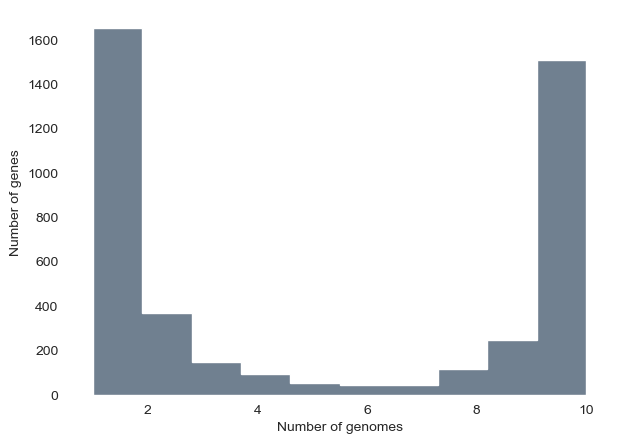

In [14]:
# Pangenome frequency plot
plt.figure(figsize=(7, 5), facecolor='white')

plt.hist(roary.sum(axis=1), roary.shape[1],
         histtype="stepfilled", alpha=1, color='slategrey')

plt.xlabel('Number of genomes')
plt.ylabel('Number of genes')

sns.despine(left=True,
            bottom=True)
plt.savefig('freq_plot.png', dpi=600, bbox_inches='tight')

In [15]:
# Sort the matrix according to tip labels in the tree
roary_sorted = roary_sorted[[x.name for x in t.get_terminals()]]

In [16]:
# Define custom tip names (replace this list with your actual strain names)
original_tip_names = ['GCF_030329025.1', 'GCF_001267315.1', 'GCF_001267255.1', 'GCF_001267215.1', 'GCF_001267195.1', 'GCF_001267175.1', 'GCF_001267295.1', 'GCF_001267275.1', 'GCF_030328955.1', 'GCF_030328995.1']
new_tip_names = ['DF92-3', 'E5571', 'D3318', 'C6918', 'C6819', 'B4199*', 'E1148', 'E1086', 'DF46-2-2', 'DF95-5']
mapping = dict(zip(original_tip_names, new_tip_names))

# Assign custom tip names to the tree
for clade in t.get_terminals():
    original_name = clade.name
    new_name = mapping.get(original_name, original_name)
    clade.name = new_name

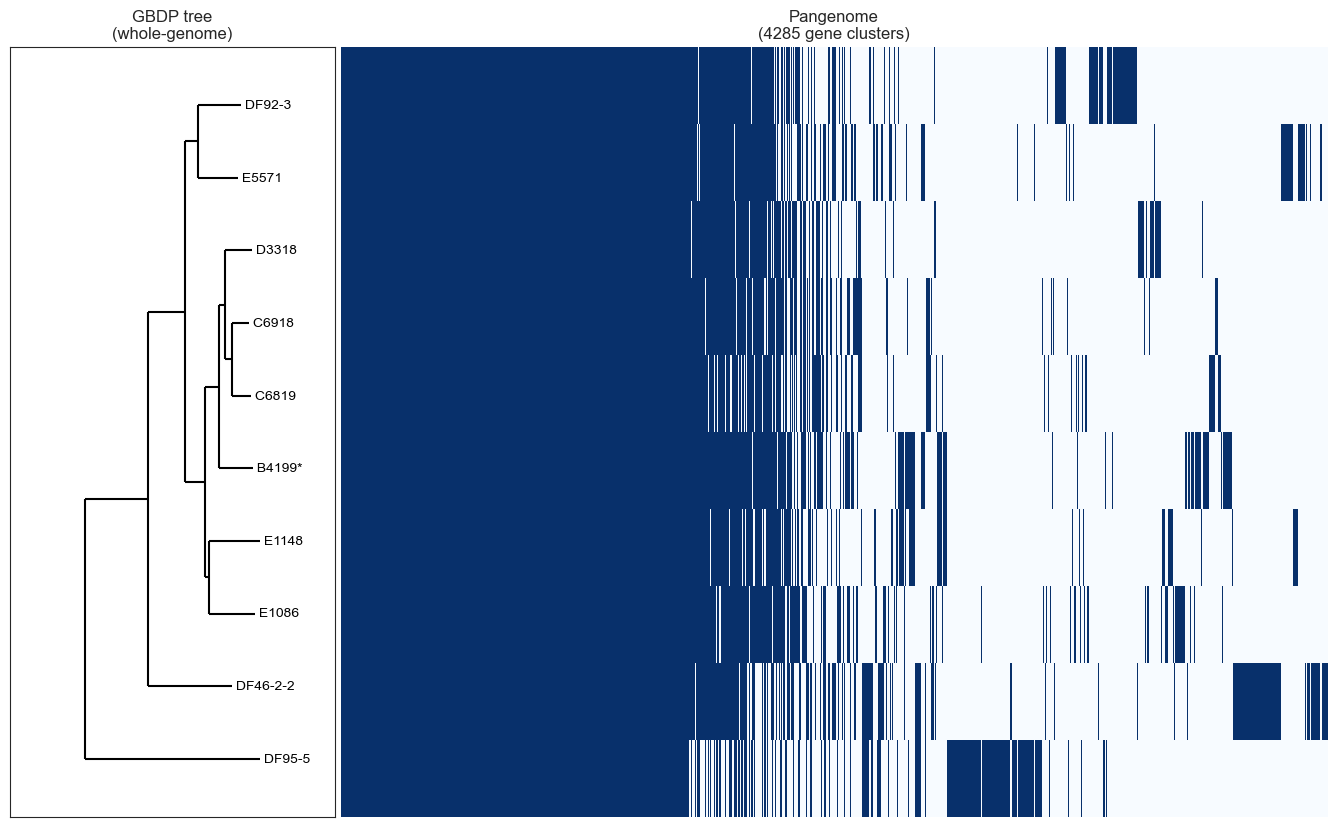

In [25]:
# Set the colormap to grayscale for black and white heatmap
custom_cmap = "Blues"

# Create the heatmap using seaborn
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))
    gs = plt.GridSpec(1, 40)

    ax1 = plt.subplot(gs[:, 10:40])
    a = ax1.imshow(roary_sorted.T, cmap=custom_cmap,
                   vmin=0, vmax=1,
                   aspect='auto',
                   interpolation='none',
                   )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')
    ax1.set_title('Pangenome\n(%d gene clusters)' % roary.shape[0])

# Create the tree plot using Bio.Phylo
with sns.axes_style('white'):  # Reset the style for the tree plot
    ax = plt.subplot(gs[:, 0:10])
    Phylo.draw(t, axes=ax,
               show_confidence=False,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01, mdist + 0.01),
               title=('GBDP tree\n(whole-genome)',),
              )
    # Remove the box around the tree plot
    for spine in ax.spines.values():
        spine.set_visible(False)

# Save both plots to a single PDF file
with PdfPages('heatmap.pdf') as pdf:
    pdf.savefig(fig)  # Save the figure with both plots

plt.close('all')  # Close all figures to free up memory

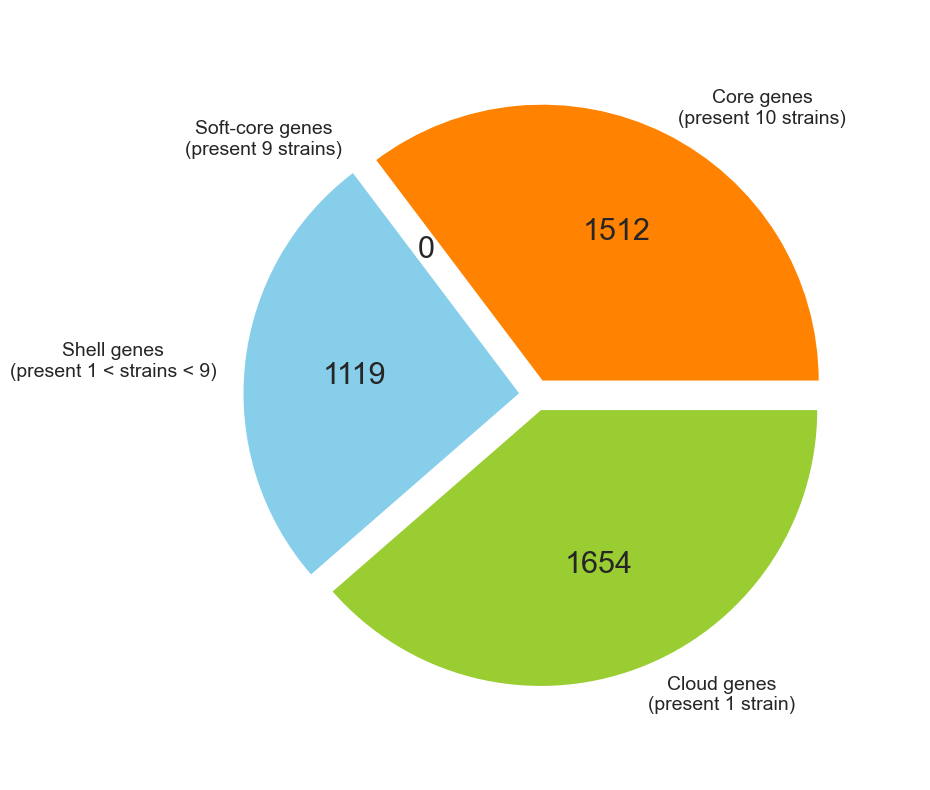

In [46]:
# Plot the pangenome pie chart
plt.figure(figsize=(10, 10))

core = roary[roary.sum(axis=1) == roary.shape[1]].shape[0]
softcore = roary[(roary.sum(axis=1) < roary.shape[1]) &
                 (roary.sum(axis=1) >= roary.shape[1]*0.95)].shape[0]
shell = roary[(roary.sum(axis=1) < roary.shape[1]*0.95) &
                 (roary.sum(axis=1) >= roary.shape[1]*0.15)].shape[0]
cloud = roary[roary.sum(axis=1) < roary.shape[1]*0.15].shape[0]

total = roary.shape[0]

def my_autopct(pct):
    val=round(pct*total/100.0)
    return '{v:d}'.format(v=val)

# Define custom colors for each section
colors = ['#FF8200', 'white', 'skyblue', 'yellowgreen']

a=plt.pie([core, softcore, shell, cloud],
      labels=['Core genes\n(present %d strains)'%roary.shape[1],
              'Soft-core genes\n(present %d strains)'%(roary.shape[1]*.95),
              'Shell genes\n(present %d < strains < %d)'%(roary.shape[1]*.15,
                                             roary.shape[1]*.95),
              'Cloud genes\n(present %d strain)'%(roary.shape[1]*.15)],
      explode=[0.05, 0.05, 0.05, 0.05], radius=0.9,
      colors=colors,
      autopct=my_autopct,textprops={'multialignment': 'center'})

# Set the font size for labels and numbers
plt.setp(a[1], size=14)
plt.setp(a[2], size=22)

plt.savefig('piechart.png', dpi=600, bbox_inches='tight')